Прообраз: https://github.com/bigartm/bigartm-book/blob/master/ARTM_example_RU.ipynb

In [180]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

BATCH_ADRESS = 'batches_news'

print(artm.version())

0.10.0


In [181]:
batch_vectorizer = artm.BatchVectorizer(
    data_path=BATCH_ADRESS, data_format='batches'
)

In [182]:
dictionary = artm.Dictionary()

# Количесвто тем
topic_count = 10

'''
model_plsa = artm.ARTM(
    topic_names=['topic_{}'.format(i) for i in range(topic_count)],
    scores=[
        artm.PerplexityScore(
            name='PerplexityScore',
            dictionary=dictionary
        )
    ],
    cache_theta=True,
    #class_ids={'text': 1.0},
)
'''

model_artm = artm.ARTM(
    topic_names=['topic_{}'.format(i) for i in range(topic_count)],
    scores=[
        artm.PerplexityScore(
            name='PerplexityScore',
            dictionary=dictionary
        )
    ],
    regularizers=[
        artm.SmoothSparseThetaRegularizer(
            name='SparseTheta', 
            tau=-0.15
        )
    ],
    cache_theta=True,
    #class_ids={'text': 1.0},
)

In [183]:
if os.path.isfile(BATCH_ADRESS + '/dictionary.dict'):
    os.remove(BATCH_ADRESS + '/dictionary.dict')
    
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary.save(dictionary_path=BATCH_ADRESS + '/dictionary.dict')

dictionary.load(dictionary_path=BATCH_ADRESS + '/dictionary.dict')

In [184]:
print(dictionary)

artm.Dictionary(name=1db1beda-7fec-48f7-a315-b0854ebdb057, num_entries=75725)


In [185]:
#model_plsa.initialize(dictionary=dictionary)
model_artm.initialize(dictionary=dictionary)

In [186]:
#model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
#model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
#model_plsa.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))

model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))
#model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))

In [187]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -0.2
model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

In [188]:
#model_plsa.num_document_passes = 1
model_artm.num_document_passes = 1

In [189]:
#model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

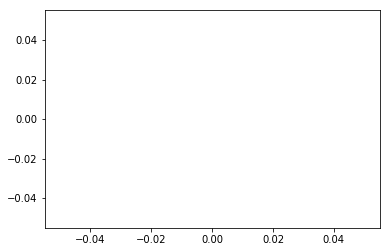

In [190]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

In [191]:
'''
def print_measures(model_plsa, model_artm):
    print(
        'Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
            model_plsa.score_tracker['SparsityPhiScore'].last_value,
            model_artm.score_tracker['SparsityPhiScore'].last_value
        )
    )

    print(
        'Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
            model_plsa.score_tracker['SparsityThetaScore'].last_value,
            model_artm.score_tracker['SparsityThetaScore'].last_value
        )
    )

    print(
        'Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
            model_plsa.score_tracker['TopicKernelScore'].last_average_contrast,
            model_artm.score_tracker['TopicKernelScore'].last_average_contrast
        )
    )

    print(
        'Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
            model_plsa.score_tracker['TopicKernelScore'].last_average_purity,
            model_artm.score_tracker['TopicKernelScore'].last_average_purity
        )
    )

    print(
        'Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
            model_plsa.score_tracker['PerplexityScore'].last_value,
            model_artm.score_tracker['PerplexityScore'].last_value
        )
    )

    plt.plot(
        range(model_plsa.num_phi_updates), model_plsa.score_tracker['PerplexityScore'].value, 'b--',
        range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2
    )
    plt.xlabel('Iterations count')
    plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    
print_measures(model_plsa, model_artm)
'''

"\ndef print_measures(model_plsa, model_artm):\n    print(\n        'Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(\n            model_plsa.score_tracker['SparsityPhiScore'].last_value,\n            model_artm.score_tracker['SparsityPhiScore'].last_value\n        )\n    )\n\n    print(\n        'Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(\n            model_plsa.score_tracker['SparsityThetaScore'].last_value,\n            model_artm.score_tracker['SparsityThetaScore'].last_value\n        )\n    )\n\n    print(\n        'Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(\n            model_plsa.score_tracker['TopicKernelScore'].last_average_contrast,\n            model_artm.score_tracker['TopicKernelScore'].last_average_contrast\n        )\n    )\n\n    print(\n        'Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(\n            model_plsa.score_tracker['TopicKernelScore'].last_average_purity,\n            model_artm.score_tracker['TopicKerne

In [192]:
#model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)

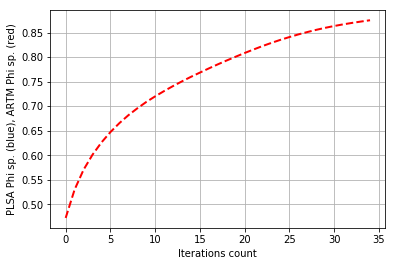

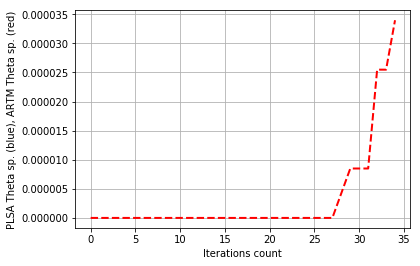

In [193]:
plt.plot(
    #range(model_plsa.num_phi_updates), model_plsa.score_tracker['SparsityPhiScore'].value, 'b--',
    range(model_artm.num_phi_updates), model_artm.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2
)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Phi sp. (blue), ARTM Phi sp. (red)')
plt.grid(True)
plt.show()

plt.plot(
    #range(model_plsa.num_phi_updates), model_plsa.score_tracker['SparsityThetaScore'].value, 'b--',
    range(model_artm.num_phi_updates), model_artm.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Theta sp. (blue), ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

In [194]:
'''
for topic_name in model_plsa.topic_names:
    print(topic_name + ': ',)
    print(model_plsa.score_tracker['TopTokensScore'].last_tokens[topic_name])
'''

"\nfor topic_name in model_plsa.topic_names:\n    print(topic_name + ': ',)\n    print(model_plsa.score_tracker['TopTokensScore'].last_tokens[topic_name])\n"

In [195]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ',)
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['дело', 'колония', 'признавать', 'статья', 'право', 'свобода']
topic_1: 
['задерживать', 'полиция', 'акция', 'полицейский', 'активист', 'рассказывать']
topic_2: 
['человек', 'который', 'свой', 'после', 'один', 'день']
topic_3: 
['который', 'россия', 'российский', 'организация', 'глава', 'также']
topic_4: 
['навальный', 'который', 'алексей', 'россия', 'рассказывать', 'написать']
topic_5: 
['дело', 'уголовный', 'статья', 'часть', 'мужчина', 'следственный']
topic_6: 
['быть', 'судья', 'адвокат', 'этот', 'дело', 'вопрос']
topic_7: 
['сообщать', 'данные', 'сотрудник', '2015', 'издание', 'москва']
topic_8: 
['быть', 'мочь', 'такой', 'этот', 'говорить', 'который']
topic_9: 
['говорить', 'быть', 'прокурор', 'убийство', 'который', 'машина']


In [196]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.8751667141914368
3.3976048143813387e-05


In [197]:
model_artm.regularizers.add(
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-5*1e5, dictionary=dictionary),
    overwrite=True,
)

In [198]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

In [199]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ',)
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['статья', 'признавать', 'колония', 'решение', 'тысяча', 'право']
topic_1: 
['рассказывать', 'задерживать', 'полиция', 'полицейский', 'группа', 'акция']
topic_2: 
['который', 'человек', 'после', 'свой', 'один', 'время']
topic_3: 
['также', 'россия', 'организация', 'российский', 'глава', '2016']
topic_4: 
['писать', 'навальный', 'представитель', 'материал', 'алексей', 'заявление']
topic_5: 
['дело', 'часть', 'уголовный', 'статья', 'следствие', 'отношение']
topic_6: 
['этот', 'быть', 'адвокат', 'судья', 'вопрос', 'свидетель']
topic_7: 
['сообщать', 'сотрудник', 'москва', 'данные', '2015', 'отмечать']
topic_8: 
['быть', 'мочь', 'весь', 'другой', 'такой', 'только']
topic_9: 
['говорить', 'убийство', 'прокурор', 'сказать', 'место', 'знать']


In [200]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.9211475849151611
0.01008663885295391


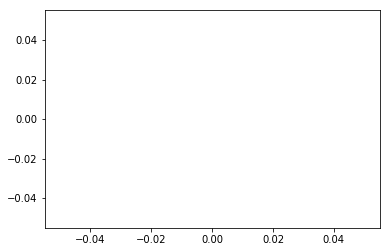

In [201]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

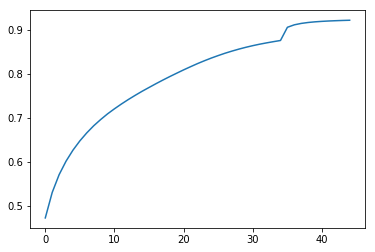

In [202]:
plt.plot(model_artm.score_tracker["SparsityPhiScore"].value)

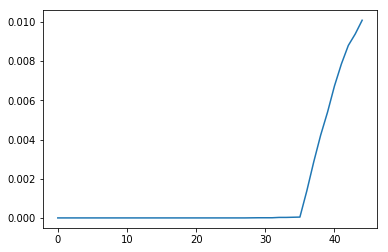

In [203]:
plt.plot(model_artm.score_tracker["SparsityThetaScore"].value)

Полезные идеи по нулевым значениям:
https://github.com/bigartm/bigartm/issues/664

In [38]:
model_artm.score_tracker

{'PerplexityScore': <artm.score_tracker.PerplexityScoreTracker at 0x104a838d0>,
 'SparsityPhiScore': <artm.score_tracker.SparsityPhiScoreTracker at 0x10ed47c88>,
 'SparsityThetaScore': <artm.score_tracker.SparsityThetaScoreTracker at 0x10ed47cf8>,
 'TopTokensScore': <artm.score_tracker.TopTokensScoreTracker at 0x1119dcbe0>,
 'TopicKernelScore': <artm.score_tracker.TopicKernelScoreTracker at 0x10ed47d30>}